In [297]:
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm, trange

import numpy as np
import cPickle as pkl
import h5py

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

class MF:
    def __init__(self, k, R, X=None, learning_rate=0.01, regularization=0.01, n_iter=100, init=0.001, bias=True):
        self.lr = learning_rate
        self.reg = regularization
        self.k = k
        self.b = bias
        
        self.R = R
        self.U = np.random.rand(self.R.shape[0], k) * init
        self.V = np.random.rand(self.R.shape[1], k) * init

        
        if X is not None:
            self.X = X
            self.W = np.random.rand(X.shape[1], k) * init
        else:
            self.X = None
            self.W = None

        self.n_iter = n_iter
        self.costs = []

    def fit(self):
        t = trange(self.n_iter, ncols=80)
        for i in t:
            c = np.mean(self.error(self.R, self.U, self.V)**2)**0.5            

            if self.X is not None:
                c2 = np.mean((self.V - self.X.dot(self.W))**2)**0.5
                t.set_description("cost {:.4f} / {:.4f}".format(c, c2))
            else:
                t.set_description("cost {:.4f}".format(c))
            self.costs.append(c)

            self.U = self.update_U(self.R, self.U, self.V, self.lr, self.reg)
            self.V = self.update_V(self.R, self.U, self.V, self.X, self.W, self.lr, self.reg, self.reg)
            
            if self.X is not None:
                self.W = self.update_W(self.V, self.X, self.W, self.lr, self.reg, self.reg)

    @staticmethod
    def error(R, U, V):
        return R - U.dot(V.T)

    @staticmethod
    def update_V(R, U, V, X, W, alpha, lambda_v, lambda_w):
        raise NotImplementedError

    @staticmethod
    def update_U(R, U, V, alpha, lambda_u):
        raise NotImplementedError

    @staticmethod
    def update_W(V, X, W, alpha, lambda_w):
        raise NotImplementedError

class GradientDescentMF(MF):
            
    @staticmethod
    def update_V(R, U, V, X, W, alpha, lambda_v, lambda_w):
        if X is None:
            dV = -(R - U.dot(V.T)).T.dot(U) + lambda_v * V
        else:
            dV = -(R - U.dot(V.T)).T.dot(U) + lambda_w * (V - X.dot(W)) + lambda_v * V
        return V - alpha * dV

    @staticmethod
    def update_U(R, U, V, alpha, lambda_u):
        dU = -(R - U.dot(V.T)).dot(V) + lambda_u * U
        return U - alpha * dU

    @staticmethod
    def update_W(V, X, W, alpha, lambda_w):
        dW = -(1./X.shape[1]) * X.T.dot(V - X.dot(W)) + lambda_w * W
        return W - alpha * dW

class ALSMF(MF):
    
    @staticmethod
    def update_V(R, U, V, X, W, alpha, lambda_v, lambda_w):
        UU = U.T.dot(U)
        k = U.shape[1]
        V_ = []
        for r in R.T:
            A = UU + lambda_v * np.eye(k)
            b = r.dot(U)
            V_.append(np.linalg.solve(A,b))
        return np.array(V_)
        
    @staticmethod
    def update_U(R, U, V, alpha, lambda_u):
        VV = V.T.dot(V)
        k = U.shape[1]
        U_ = []
        for r in R:
            A = VV + lambda_u * np.eye(k)
            b = r.dot(V)
            U_.append(np.linalg.solve(A,b))
        return np.array(U_)

class ALSMF2(MF):

    @staticmethod
    def update_V(R, U, V, X, W, alpha, lambda_v, lambda_w):
        UU = U.T.dot(U)
        k = U.shape[1]
        V_ = []
        for r, x in zip(R.T, X):
            A = UU + lambda_v * np.eye(k)
            b = r.dot(U) + lambda_v * x.dot(W)
            V_.append(np.linalg.solve(A,b))
        return np.array(V_)
        
    @staticmethod
    def update_U(R, U, V, alpha, lambda_u):
        VV = V.T.dot(V)
        k = U.shape[1]
        U_ = []
        for r in R:
            A = VV + lambda_u * np.eye(k)
            b = r.dot(V)
            U_.append(np.linalg.solve(A,b))
        return np.array(U_)
        
    @staticmethod
    def update_W(V, X, W, alpha, lambda_w, lambda_v):
        d = X.shape[1]
        A = lambda_v * X.T.dot(X) + lambda_w * np.eye(d)
        b = lambda_v * X.T.dot(V)
        return np.linalg.solve(A,b)

In [2]:
data = pkl.load(open('/mnt/bulk2/datasets/JamDataset/subset.db.pkl'))
R = data['R']

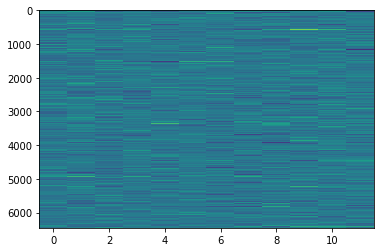

In [350]:
# mfcc feature
with h5py.File('/home/ubuntu/workbench/MTLMusicRepresentation/data/conv_2d_tag_50_0.0001_ThisIsMyJam_feature.h5') as hf:
    X = hf['X'][:]
    keep_id = np.where(1 - (np.isnan(X).sum(axis=1) > 0))[0]
    
X = np.load('/mnt/bulk2/datasets/JamDataset/mfcc_feat_subdb.npy')[keep_id]

# sclr = StandardScaler()
# Z = sclr.fit_transform(X)

pca = PCA(n_components=12, whiten=True)
Z = pca.fit_transform(sclr.fit_transform(X))

# Z = X
plt.imshow(Z, aspect='auto')

R = data['R'].toarray()[:,keep_id]

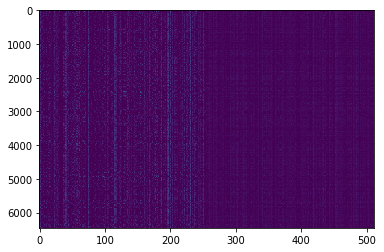

In [320]:
# nn feature
with h5py.File('/home/ubuntu/workbench/MTLMusicRepresentation/data/conv_2d_tag_50_0.0001_ThisIsMyJam_feature.h5') as hf:
    X = hf['X'][:]
    keep_id = np.where(1 - (np.isnan(X).sum(axis=1) > 0))[0]

# sclr = StandardScaler()
# Z = sclr.fit_transform(X[keep_id])

# pca = PCA(n_components=64, whiten=True)
# Z = pca.fit_transform(sclr.fit_transform(X[keep_id]))
# Z = pca.fit_transform(X[keep_id])

Z = X[keep_id]
plt.imshow(Z, aspect='auto')

R=data['R'].toarray()[:,keep_id]

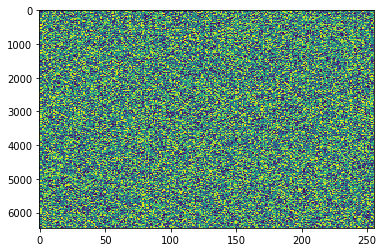

In [336]:
# random feature
import h5py
with h5py.File('/home/ubuntu/workbench/MTLMusicRepresentation/data/conv_2d_tag_50_0.0001_ThisIsMyJam_feature.h5') as hf:
    X = hf['X'][:]
    keep_id = np.where(1 - (np.isnan(X).sum(axis=1) > 0))[0]

Z = np.random.rand(len(keep_id), 256)
plt.imshow(Z, aspect='auto')

R=data['R'].toarray()[:,keep_id] 


In [358]:
# rnd_idx = np.random.choice(R.shape[1], R.shape[1], replace=False)
# trn_idx = rnd_idx[:-600]
# tst_idx = rnd_idx[-600:]
# print(len(rnd_idx), len(trn_idx), len(tst_idx))

train = R[:,trn_idx]
test = R[:,tst_idx]

print 'train_user_fail', (train.sum(axis=1)==0).sum()
print 'test_user_fail', (test.sum(axis=1)==0).sum()
print 'test_item_fail', (test.sum(axis=0)==0).sum()

keep_user_to_train = np.where(train.sum(axis=1)>0)[0]
keep_user_to_test = set(np.where(test.sum(axis=1)>0)[0]) & set(keep_user_to_train)
keep_user_to_test = list(keep_user_to_test)

Atr = train[keep_user_to_train]
Ats = test[keep_user_to_test]
Ztr = Z[trn_idx]
Zts = Z[tst_idx]


train_user_fail 11
test_user_fail 2359
test_item_fail 0


In [352]:
# from tqdm import tqdm
# mf = MF(k=50, R=R.toarray(), X=Z[:,:110], learning_rate=0.001, regularization=1., n_iter=100, init=0.01)
mf = ALSMF2(k=20, R=Atr, X=Ztr, learning_rate=0.01, regularization=.5, n_iter=50, init=0.01) 
# mf = ALSMF(k=20, R=Atr, learning_rate=0.01, regularization=.5, n_iter=50, init=0.01)
mf.fit()

cost 0.0597 / 0.0758: 100%|█████████████████████| 50/50 [00:48<00:00,  1.07it/s]


In [ ]:
res = []
M = 10
for r, u in tqdm(zip(mf.R, mf.U)):
    pred = np.argsort(u.dot(mf.V.T).tolist())[-M:]
    true = np.where(r>0)[0]
    pred_rank = [np.where(np.argsort(u.dot(mf.V.T).tolist())[-M:] == t)[0] for t in true]
    pred_rank = filter(lambda x:len(x) > 0, pred_rank)
    
    res.append(float(len(pred_rank)) / len(true))
print(np.mean(res))

In [371]:
res = []
M = 40
rnd_V = np.random.rand(Ats.shape[1], mf.k)

for r, u in tqdm(zip(Ats, mf.U)):
    true = np.where(r>0)[0]

    pred = np.argsort(u.dot(Zts.dot(mf.W).T))[-M:]
    pred_rank = [np.where(pred == t)[0].tolist() for t in true]

#     pred = np.argsort(u.dot(rnd_V.T))[-M:]
#     pred_rank = [np.where(np.argsort(u.dot(rnd_V.T).tolist())[-M:] == t)[0] for t in true]
    pred_rank = map(lambda x:x[0], filter(lambda x:len(x) > 0, pred_rank))
    
    res.append(float(len(pred_rank)) / len(true))
print(np.mean(res))

100%|██████████| 2347/2347 [00:00<00:00, 7116.39it/s]

0.0690424436832


In [362]:
res

[0.0,
 0.0,
 0.25,
 0.0,
 0.10714285714285714,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.07142857142857142,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.18181818181818182,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.09090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.5,
 0.06111111111111111,
 0.06666666666666667,
 0.0,
 0.16666666666666666,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.09090909090909091,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.07692307692307693,
 0.0,
 1.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.16666666666666666,
 0.0,
 0.0,
 0.056179775280898875,
 0.0,
 0.16666666666666666,
 0.0,
 0.0,
 0.0,
 0.02040816326530612,
 0.5,
 1.0,
 0.0,
 0.0,
 0.21052631578947367,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.2,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.13043478260869565,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.3333333333333333,
 0.0,
 0.0,
 0.0,
 0.3333333333333333,
 0.09090909090909091,
 0.0,
 0.0

In [345]:
# no preproc
# outer-matrix (unseen song) performance (recall@40)
nn_artist = [0.0768999767579, 0.0776491558645, 0.0769549636675]
mfcc = [0.061880243579, 0.060731077618, 0.0699362259134]
rnd = [0.0700572413622, 0.0703290162506, 0.0704313940486]
no_side = [[0.0679905214918, 0.0576784039172, 0.0645175058895, 0.0674324009192, 0.0714764659684],
          [0.0706824742536, 0.0713288382424, 0.066727891581, 0.0647979486274, 0.0715310937006],
          [0.0677561306285, 0.0646759897464, 0.0653642226299, 0.067458817517, 0.0584980614978],
          [0.0747855086816, 0.0706642663895, 0.0587766578149, 0.0689431480393, 0.0645087464505],
          [0.0563833217951, 0.0506871592333, 0.0589762660228, 0.0719818829197, 0.0667605193554]]

print 'artist', np.mean(nn_artist), np.std(nn_artist)
print 'mfcc', np.mean(mfcc), np.std(mfcc)
print 'random', np.mean(rnd), np.std(rnd)
print 'no_side', np.mean(no_side), np.std(no_side)

artist 0.0771680320966 0.000340945694661
mfcc 0.0641825157035 0.00409544718652
random 0.0702725505538 0.000157879361901
no_side 0.0656153697325 0.00574439921433


In [314]:
# PCA k=64
# outer-matrix (unseen song) performance (recall@40)
nn_artist = [0.0704487691252, 0.0708752597815, 0.0760261733135, 0.0701935869928, 0.0702742663929]
mfcc = [0.0716525470386, 0.0698440216586, 0.069768088691, 0.0709245749691, 0.0692773668655]
rnd = [0.0735688394958, 0.072800284659, 0.0714114638416, 0.0737303203211, 0.0724698067828]
no_side = [[0.0679905214918, 0.0576784039172, 0.0645175058895, 0.0674324009192, 0.0714764659684],
          [0.0706824742536, 0.0713288382424, 0.066727891581, 0.0647979486274, 0.0715310937006],
          [0.0677561306285, 0.0646759897464, 0.0653642226299, 0.067458817517, 0.0584980614978],
          [0.0747855086816, 0.0706642663895, 0.0587766578149, 0.0689431480393, 0.0645087464505],
          [0.0563833217951, 0.0506871592333, 0.0589762660228, 0.0719818829197, 0.0667605193554]]


print 'artist', np.mean(nn_artist), np.std(nn_artist)
print 'mfcc', np.mean(mfcc), np.std(mfcc)
print 'random', np.mean(rnd), np.std(rnd)
print 'no_side', np.mean(no_side), np.std(no_side)

artist 0.0715636111212 0.00224368168437
mfcc 0.0702933198446 0.000866703949168
random 0.0727961430201 0.000835894250917
no_side 0.0656153697325 0.00574439921433


In [236]:
# PCA k=128
# outer-matrix (unseen song) performance (recall@40)
nn_artist = [0.071913405423, 0.0733855718801, 0.0730556484788, 0.0741539743845, 0.0731417314331]
mfcc = [0.0665086268474, 0.0680955923083, 0.0667683898473, 0.0676403192207, 0.0677313635322]
rnd = [0.0652537053447, 0.0652537053447, 0.064288298906, 0.0655869950726, 0.065135396464]
no_side = [[0.0679905214918, 0.0576784039172, 0.0645175058895, 0.0674324009192, 0.0714764659684],
          [0.0706824742536, 0.0713288382424, 0.066727891581, 0.0647979486274, 0.0715310937006],
          [0.0677561306285, 0.0646759897464, 0.0653642226299, 0.067458817517, 0.0584980614978],
          [0.0747855086816, 0.0706642663895, 0.0587766578149, 0.0689431480393, 0.0645087464505],
          [0.0563833217951, 0.0506871592333, 0.0589762660228, 0.0719818829197, 0.0667605193554]]

print 'artist', np.mean(nn_artist), np.std(nn_artist)
print 'mfcc', np.mean(mfcc), np.std(mfcc)
print 'random', np.mean(rnd), np.std(rnd)
print 'no_side', np.mean(no_side), np.std(no_side)

artist 0.0731300663199 0.000721055981742
mfcc 0.0673488583512 0.000605277443595
random 0.0651036202264 0.000434617282718
no_side 0.0656153697325 0.00574439921433


In [160]:
nn_artist = [0.237243991011, 0.236992858427, 0.237510503753, 0.237510503753]
mfcc = [0.236883955018, 0.23752387068, 0.236079953791, 0.237275893287]
no_side = [0.236924750428, 0.237306560677, 0.237117014436, 0.23747800221]

print 'artist', np.mean(nn_artist)
print 'mfcc', np.mean(mfcc)
print 'no_side', np.mean(no_side)

artist 0.237314464236
mfcc 0.236940918194
no_side 0.237206581938


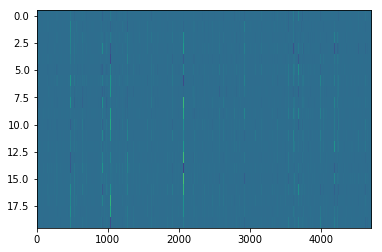

In [177]:
plt.imshow(mf.U.T, aspect='auto')

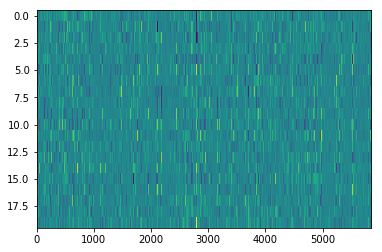

In [178]:
plt.imshow(mf.V.T, aspect='auto')

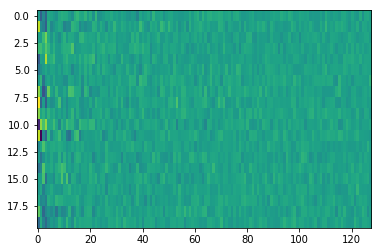

In [179]:
plt.imshow(mf.W.T, aspect='auto')

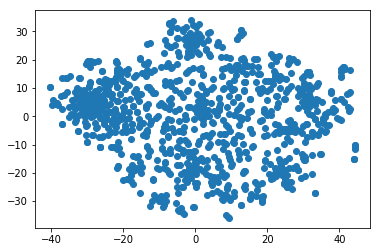

In [180]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)

v = tsne.fit_transform(mf.V[np.random.choice(mf.V.shape[0], 1000, replace=False)])

plt.scatter(v[:,0], v[:,1])

In [106]:
from math import log
import unittest

def dcg_at_k(scores):
    assert scores
    return scores[0] + sum(sc / log(ind, 2) for sc, ind in zip(scores[1:], range(2, len(scores)+1)))

def ndcg_at_k(predicted_scores, user_scores):
    assert len(predicted_scores) == len(user_scores)
    idcg = dcg_at_k(sorted(user_scores, reverse=True))
    return (dcg_at_k(predicted_scores) / idcg) if idcg > 0.0 else 0.0

# from sklearn.metrics import average_precision_score as metric
metric = ndcg_at_k

res = []
for r, u in zip(mf.R, mf.U):
    res.append(metric(u.dot(mf.V.T).tolist(), r.tolist()))
print(np.mean(res))

0.16964880733
